In [1]:
import pandas as pd

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%pylab inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations
from numpy import array,array_equal

from sklearn import cross_validation as cv
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 

import xgboost as xgb


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from subprocess import check_output
print check_output(["ls", "./input"]).decode("utf8")


# Any results you write to the current directory are saved as output.
def print_shapes():
    print 'Train: {}\nTest: {}'.format(train_dataset.shape, test_dataset.shape)
    
train_dataset = pd.read_csv('./input/train.csv', index_col='ID')
test_dataset = pd.read_csv('./input/test.csv', index_col='ID')



Populating the interactive namespace from numpy and matplotlib
test.csv
train.csv



In [27]:
print_shapes()

# How many nulls are there in the datasets?
nulls_train = (train_dataset.isnull().sum()==1).sum()
nulls_test = (test_dataset.isnull().sum()==1).sum()
print 'There are {} nulls in TRAIN and {} nulls in TEST dataset.'.format(nulls_train, nulls_test) 
# Remove constant features

def identify_constant_features(dataframe):
    count_uniques = dataframe.apply(lambda x: len(x.unique()))
    constants = count_uniques[count_uniques == 1].index.tolist()
    return constants

constant_features_train = set(identify_constant_features(train_dataset))

# print 'There were {} constant features in TRAIN dataset.'.format(len(constant_features_train))

# Drop the constant features
train_dataset.drop(constant_features_train, inplace=True, axis=1)
test_dataset.drop(constant_features_train, inplace=True, axis=1)

print_shapes()
# Remove equals features

def identify_equal_features(dataframe):
    features_to_compare = list(combinations(dataframe.columns.tolist(),2))
    equal_features = []
    for compare in features_to_compare:
        is_equal = array_equal(dataframe[compare[0]],dataframe[compare[1]])
        if is_equal:
            equal_features.append(list(compare))
    return equal_features

equal_features_train = identify_equal_features(train_dataset)
# print equal_features_train
print 'There were {} pairs of equal features in TRAIN dataset.'.format(len(equal_features_train))

# Remove the second feature of each pair.
if len(equal_features_train) > 0:
    features_to_drop = array(equal_features_train)[:,1]

    train_dataset.drop(features_to_drop, axis=1, inplace=True)
    test_dataset.drop(features_to_drop, axis=1, inplace=True)

print_shapes()
# Define the variables model.

y_name = 'TARGET'
feature_names = train_dataset.columns.tolist()
feature_names.remove(y_name)

X = train_dataset[feature_names]
y = train_dataset[y_name]

X_test = test_dataset[feature_names]


# Save the features selected for later use.
pd.Series(feature_names).to_csv('features_selected_step1.csv', index=False)
# print 'Features selected\n{}'.format(feature_names)
   
    
# Proportion of classes
y.value_counts()/len(y)

skf = cv.StratifiedKFold(y, n_folds=3, shuffle=True)
score_metric = 'roc_auc'
scores = {}


from sklearn.cross_validation import train_test_split
from sklearn import metrics
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=1)

def print_shapes_split():
    print 'X: {}\ny: {} '.format(np.shape(X), np.shape(y))
    print 'XTrain: {}\nXTest: {} \nyTrain: {}\nyTest: {}'.format(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

print_shapes_split()

def score_model(model):
    return cv.cross_val_score(model, X_train, y_train, cv=skf, scoring=score_metric)

# time: 10s
scores['tree'] = score_model(tree.DecisionTreeClassifier()) 

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())

# time: 3s
scores['gaussian'] = score_model(naive_bayes.GaussianNB())

# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())


# Print the scores
model_scores = pd.DataFrame(scores).mean()
model_scores.sort_values(ascending=False)
model_scores.to_csv('model_scores.csv', index=False)
print 'Model scores\n{}'.format(model_scores)

Train: (76020, 307)
Test: (75818, 306)
There are 0 nulls in TRAIN and 0 nulls in TEST dataset.
Train: (76020, 307)
Test: (75818, 306)
There were 0 pairs of equal features in TRAIN dataset.
Train: (76020, 307)
Test: (75818, 306)
X: (76020, 306)
y: (76020,) 
XTrain: (38010, 306)
XTest: (38010, 306) 
yTrain: (38010,)
yTest: (38010,)


IndexError: index 38011 is out of bounds for axis 0 with size 38010

In [6]:
clfTree = tree.DecisionTreeClassifier()
clfTree = clfTree.fit(X, y)
probTree = clfTree.predict_proba(X)[:,1]

In [7]:
print np.shape(probTree)


(76020,)


In [8]:
clfExtraTree = tree.ExtraTreeClassifier()
clfExtraTree = clfExtraTree.fit(X, y)
probExtraTree = clfExtraTree.predict_proba(X)[:,1]


In [9]:
print np.shape(probExtraTree)

(76020,)


In [10]:
clfforest = ensemble.RandomForestClassifier()
clfforest = clfforest.fit(X, y)
probforest = clfforest.predict_proba(X)[:,1]
print 'forest', np.shape(probforest)

clfada = ensemble.AdaBoostClassifier()
clfada = clfada.fit(X, y)
probada = clfada.predict_proba(X)[:,1]
print 'Adaboost', np.shape(probada)

clfBagging = ensemble.BaggingClassifier()
clfBagging = clfBagging.fit(X, y)
probBagging = clfBagging.predict_proba(X)[:,1]
print 'Bagging', np.shape(probBagging)

clfGradientBoosting = ensemble.GradientBoostingClassifier()
clfGradientBoosting = clfGradientBoosting.fit(X, y)
probGradientBoosting = clfGradientBoosting.predict_proba(X)[:,1]
print 'Gboosting', np.shape(probGradientBoosting)


forest (76020,)
Adaboost (76020,)
Bagging (76020,)
Gboosting (76020,)


In [11]:

clfRidge = linear_model.RidgeClassifier()
clfRidge = clfRidge.fit(X, y)
probRidge = clfRidge.decision_function(X)
print 'Ridge', np.shape(probRidge)

clfPassiveAggressive = linear_model.PassiveAggressiveClassifier()
clfPassiveAggressive = clfPassiveAggressive.fit(X, y)
probPassiveAggressive = clfPassiveAggressive.decision_function(X)
print 'Pasiive', np.shape(probPassiveAggressive)

clfSGD = linear_model.SGDClassifier()
clfSGD = clfSGD.fit(X, y)
probSGD = clfSGD.decision_function(X)
print 'SGD', np.shape(probSGD)

clfNB = naive_bayes.GaussianNB()
clfNB = clfNB.fit(X, y)
probNB = clfNB.predict_proba(X)[:,1]
print 'NB', np.shape(probNB)


clfxgb = xgb.XGBClassifier()
clfxgb = clfxgb.fit(X, y)
probxgb = clfxgb.predict_proba(X)[:,1]
print 'XGB', np.shape(probxgb)

Ridge (76020,)
Pasiive (76020,)
SGD (76020,)
NB (76020,)
XGB (76020,)


In [12]:
X_en = np.vstack([probforest, probBagging, probExtraTree, probGradientBoosting, probNB, probPassiveAggressive, probRidge, probSGD, probTree, probada, probxgb])
X_enT = X_en.T
print np.shape(X_enT)

(76020, 11)


In [35]:
# clf_xgbF = xgb.fit(X_enT, y)
# pred = clf_xgbF.predict(X)
print 'XGB Score', cv.cross_val_score(xgb.XGBClassifier(), X_enT, y, cv=skf, scoring=score_metric)
print 'Grad Boost Score', cv.cross_val_score(ensemble.GradientBoostingClassifier(), X_enT, y, cv=skf, scoring=score_metric)
print 'Ada Boost Score', cv.cross_val_score(ensemble.AdaBoostClassifier(), X_enT, y, cv=skf, scoring=score_metric)

XGB Score [ 0.99915106  0.99874277  0.99909945]
Grad Boost Score [ 0.99903568  0.99863058  0.99901069]
Ada Boost Score [ 0.9989849   0.99846766  0.99888894]


In [18]:

clf_xgbF = clfxgb.fit(X_enT, y)
#pred = clf_xgbF.predict(X_test)


/home/harsh/Projects/enviro/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/harsh/Projects/enviro/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=400:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


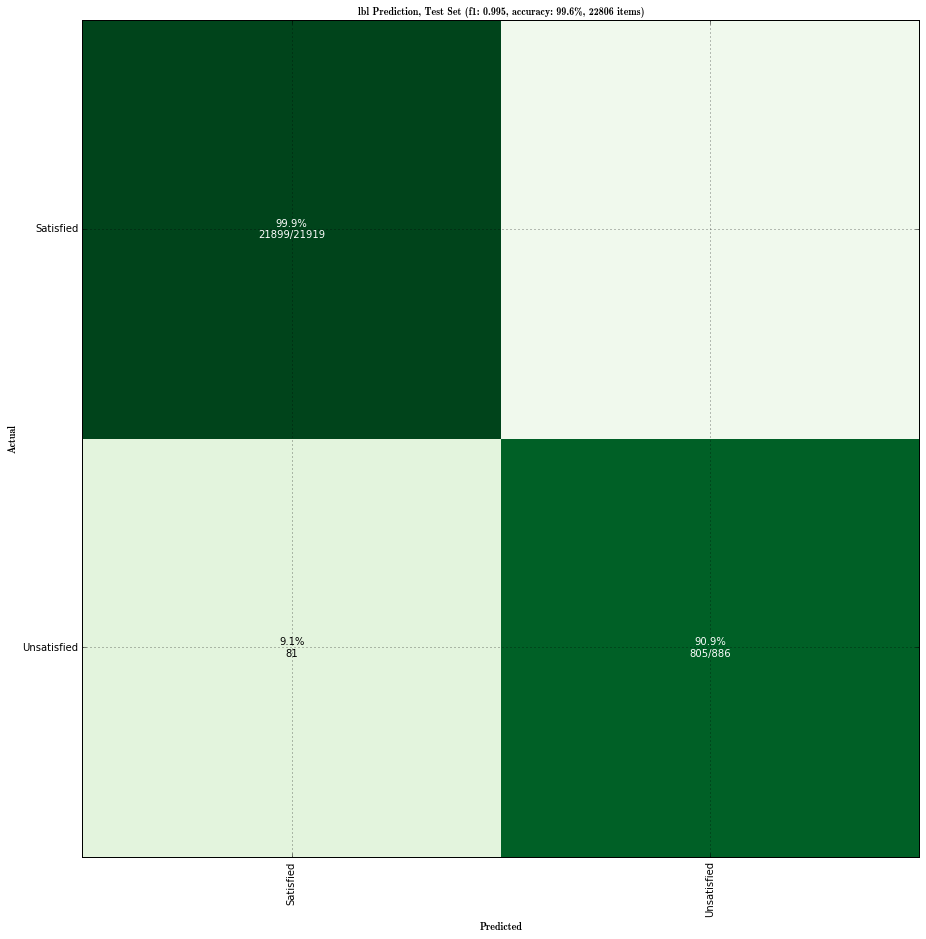

In [14]:

# Evaluating Performance

import numpy as np, pylab as pl
# get overall accuracy and F1 score to print at top of plot
pscore = metrics.accuracy_score(y_test, pred)
score = metrics.f1_score(y_test, pred, pos_label=list(set(y_test)))
# get size of the full label set
categories = ["Satisfied", "Unsatisfied"]
dur = len(categories)
#print "Building testing confusion matrix..."
# initialize score matrices
trueScores = np.zeros(shape=(dur,dur))
predScores = np.zeros(shape=(dur,dur))
# populate totals
for i in xrange(len(y_test)-1):
  trueIdx = y_test[i]
  predIdx = pred[i]
  trueScores[trueIdx,trueIdx] += 1
  predScores[trueIdx,predIdx] += 1
# create %-based results
trueSums = np.sum(trueScores,axis=0)
conf = np.zeros(shape=predScores.shape)
for i in xrange(len(predScores)):
  for j in xrange(dur):
    conf[i,j] = predScores[i,j] / trueSums[i]
# plot the confusion matrix
hq = pl.figure(figsize=(15,15));
aq = hq.add_subplot(1,1,1)
aq.set_aspect(1)
res = aq.imshow(conf,cmap=pl.get_cmap('Greens'),interpolation='nearest',vmin=-0.05,vmax=1.)
width = len(conf)
height = len(conf[0])
done = []
# label each grid cell with the misclassification rates
for w in xrange(width):
  for h in xrange(height):
      pval = conf[w][h]
      c = 'k'
      rais = w
      if pval > 0.5: c = 'w'
      if pval > 0.001:
        if w == h:
          aq.annotate("{0:1.1f}%\n{1:1.0f}/{2:1.0f}".format(pval*100.,predScores[w][h],trueSums[w]), xy=(h, w), 
                  horizontalalignment='center',
                  verticalalignment='center',color=c,size=10)
        else:
          aq.annotate("{0:1.1f}%\n{1:1.0f}".format(pval*100.,predScores[w][h]), xy=(h, w), 
                  horizontalalignment='center',
                  verticalalignment='center',color=c,size=10)
# label the axes
pl.xticks(range(width), categories[:width],rotation=90,size=10)
pl.yticks(range(height), categories[:height],size=10)
# add a title with the F1 score and accuracy
aq.set_title("lbl" + " Prediction, Test Set (f1: "+"{0:1.3f}".format(score)+', accuracy: '+'{0:2.1f}%'.format(100*pscore)+", " + str(len(y_test)) + " items)",fontname='Arial',size=10,color='k')
aq.set_ylabel("Actual",fontname='Arial',size=10,color='k')
aq.set_xlabel("Predicted",fontname='Arial',size=10,color='k')
pl.grid(b=True,axis='both')
# save it
pl.savefig("pred.conf.test.png")

In [15]:
#Testing
print np.shape(test_dataset) 

(75818, 306)


In [16]:
XTest = test_dataset
testprobTree = clfTree.predict_proba(XTest)[:,1]
testprobExtraTree = clfExtraTree.predict_proba(XTest)[:,1]
testprobforest = clfforest.predict_proba(XTest)[:,1]
testprobada = clfada.predict_proba(XTest)[:,1]
testprobBagging = clfBagging.predict_proba(XTest)[:,1]
testprobGradientBoosting = clfGradientBoosting.predict_proba(XTest)[:,1]
testprobRidge = clfRidge.decision_function(XTest)
testprobPassiveAggressive = clfPassiveAggressive.decision_function(XTest)
testprobSGD = clfSGD.decision_function(XTest)
testprobNB = clfNB.predict_proba(XTest)[:,1]
testprobxgb = clfxgb.predict_proba(XTest)[:,1]

X_entest = np.vstack([testprobforest, testprobBagging, testprobExtraTree, testprobGradientBoosting, testprobNB, testprobPassiveAggressive, testprobRidge, testprobSGD, testprobTree, testprobada, testprobxgb])
X_en_test = X_entest.T

In [19]:
# predTest = clf_xgbF.predict(X_en_test)
# clf_xgbF.predict(
#clf_xgbF = clfxgb.fit(X_enT, y)

print np.shape(X_en_test)
predTest = clf_xgbF.predict(X_en_test)

(75818, 11)


In [20]:
df_test = pd.read_csv('./input/test.csv')
id_test = df_test['ID']

In [21]:
submission = pd.DataFrame({"ID":id_test, "TARGET":predTest})
submission.to_csv("submission.csv", index=False)